## IMPORTS

In [1]:
import cv2
import numpy as np
import pandas as pd
SEED =12
def load_labels(label_file):
    """Loads image filenames, classes, and bounding boxes"""
    fnames, classes, bboxes = [], [], []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            fnames.append(fname)
            classes.append(int(cls))
            bboxes.append((int(xmin), int(ymin), int(xmax), int(ymax)))
    fnames = ["/kaggle/input/covidxct/3A_images/" + fname for fname in fnames]
    fnames = np.array(fnames)
    classes = np.array(classes)
    return fnames, classes, bboxes

def index_generator(fnames , SET):
    """Genrated random index of a particular class"""
    np.random.seed(SEED)
    index = np.random.randint(1,len(fnames),size = SET)
    return index 

def numberofclasses(classes, index):
    class0 = len((np.where(classes[index]==0))[0])
    class1 = len((np.where(classes[index]==1))[0])
    class2 = len((np.where(classes[index]==2))[0])
    return class0  , class1, class2
def dataframe_generator(train_index , valid_index , classes_train , classes_valid ):
    """Returns 1 dataframes of datasets distribution"""
    index = ["Normal" , "Pneumonia" , "COIVD -19"]
    train_DF = numberofclasses(classes_train, train_index)
    valid_DF = numberofclasses(classes_valid, valid_index)
    df = pd.DataFrame({'train': train_DF ,'valid' : valid_DF} , index = index)
    return df
def train_index_updater(classes_train , train_index,n ):
    """Updates train_index for class balance"""
    np.random.seed(SEED)
    class0_train = np.where(classes_train[train_index]==0)[0]
    class1_train = np.where(classes_train[train_index]==1)[0]
    class2_train = np.where(classes_train[train_index]==2)[0]
    class0 =train_index[class0_train]
    class1 = train_index[class1_train]
    np.random.seed(SEED)
    class22 = np.random.choice(class2_train , n)
    class2 = train_index[class22]
    train_index_updated = np.concatenate((class0 , class1 , class2))
    np.random.shuffle(train_index_updated)
    return train_index_updated

def data_constructor(filepath, classes , dim_size ,index  ,bboxes , interpolation = cv2.INTER_AREA , intensify =False):
    """Constructs and splits X and Y for training , validtion and test"""
    np.random.seed(SEED)
    y = np.array(classes[index])
    x = []
    for i in index:
        img  = cv2.imread(filepath[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x1,y1,x2,y2 = bboxes[i]
        img = img[y1:y2,x1:x2]
        img = cv2.resize(img, dim_size , interpolation = interpolation)
        # add SR step here
        x.append(img)
    
    x = np.array(x)
    if intensify == True:
        x= x/255
    return x , y 

In [2]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
sns.set(style = "darkgrid")

## SETTING UP PARAMETERS AND DIRECTORIES

In [3]:
SEED = 12
IMG_HEIGHT = 128
IMG_WIDTH = 128
DIM = (IMG_HEIGHT, IMG_WIDTH)
TRAIN_SET= 46778
VALID_SET= 6486
EPOCHS = 40
BS = 32
n = 8000
LR = 0.0001
label_file_train = "/kaggle/input/covidxct/train_COVIDx_CT-3A.txt"
label_file_valid = "/kaggle/input/covidxct/val_COVIDx_CT-3A.txt"

## LOADING DATA

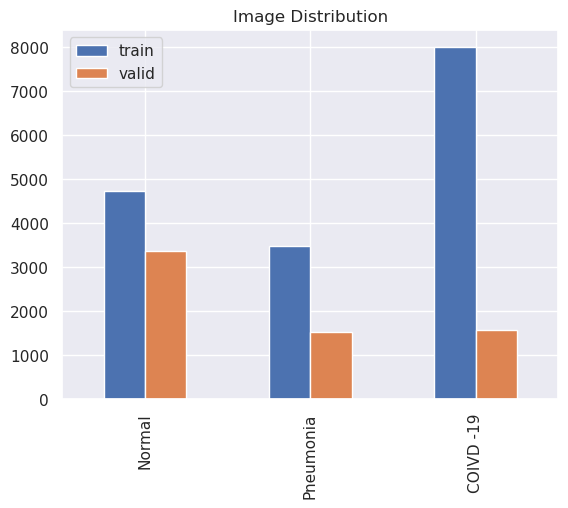

In [4]:
fnames_train, classes_train, bboxes_train = load_labels(label_file_train)
fnames_valid, classes_valid, bboxes_valid = load_labels(label_file_valid)
train_index = index_generator(fnames_train, TRAIN_SET)
valid_index = index_generator(fnames_valid, VALID_SET)
train_index_updated = train_index_updater(classes_train,train_index, n)
df = dataframe_generator(train_index_updated, valid_index, classes_train, classes_valid)
df.plot.bar(title = "Image Distribution");

## Loading Training and Validation Images

In [5]:
x_train, y_train = data_constructor(fnames_train, classes_train, DIM, index=train_index_updated, bboxes = bboxes_train)
x_valid , y_valid= data_constructor(fnames_valid, classes_valid, DIM, index=valid_index, bboxes = bboxes_valid)

## Pre-Processing

In [6]:
x_train = tf.keras.applications.densenet.preprocess_input(x_train)
x_valid = tf.keras.applications.densenet.preprocess_input(x_valid)

In [7]:
for i in range(len(y_train)):
    if y_train[i] ==1:
        y_train[i]=0
    if y_train[i] ==2:
        y_train[i]=1
for i in range(len(y_valid)):
    if y_valid[i] ==1:
        y_valid[i]=0
    if y_valid[i]==2:
        y_valid[i]=1

In [8]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,zoom_range=0.05,width_shift_range=0.2 ,height_shift_range=0.1,shear_range=0.05)## ENTER YOUR AUG HERE
train_generator = data_generator.flow(x_train, y_train, BS)
spe = x_train.shape[0] // BS

## MODEL DESIGN

In [9]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [10]:
base_model = DenseNet201(include_top=False,weights="imagenet",input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
model= tf.keras.Sequential()
model.add(base_model) 
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(1,activation=('sigmoid')))

74836368/74836368 [==============================] - 2s 0us/step


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                122944    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,444,993
Trainable params: 18,215,937
Non-trainable params: 229,056
______________________________________

In [12]:
model.compile(optimizer=tf.keras.optimizers.SGD(LR),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelsdir = "models"
checkpoint = ModelCheckpoint(filepath = modelsdir + "/SGD.{epoch:02d}-{val_accuracy:.4f}.h5" ,
                             monitor= "val_accuracy" , 
                             mode = "max",
                            verbose = 0,
                            save_best_only=True)

In [14]:
r = model.fit(train_generator , validation_data=(x_valid, y_valid), steps_per_epoch = spe ,epochs=EPOCHS, callbacks = [checkpoint])

Epoch 1/40
507/507 [==============================] - 199s 265ms/step - loss: 0.6677 - accuracy: 0.6040 - val_loss: 0.6923 - val_accuracy: 0.5811
Epoch 2/40
507/507 [==============================] - 137s 270ms/step - loss: 0.5462 - accuracy: 0.7286 - val_loss: 0.5920 - val_accuracy: 0.6792
Epoch 3/40
507/507 [==============================] - 127s 250ms/step - loss: 0.4644 - accuracy: 0.7956 - val_loss: 0.5702 - val_accuracy: 0.7027
Epoch 4/40
507/507 [==============================] - 138s 271ms/step - loss: 0.4190 - accuracy: 0.8244 - val_loss: 0.5609 - val_accuracy: 0.7160
Epoch 5/40
507/507 [==============================] - 127s 250ms/step - loss: 0.3824 - accuracy: 0.8450 - val_loss: 0.5023 - val_accuracy: 0.7566
Epoch 6/40
507/507 [==============================] - 126s 249ms/step - loss: 0.3495 - accuracy: 0.8599 - val_loss: 0.5136 - val_accuracy: 0.7495
Epoch 7/40
507/507 [==============================] - 127s 250ms/step - loss: 0.3300 - accuracy: 0.8690 - val_loss: 0.4980 -

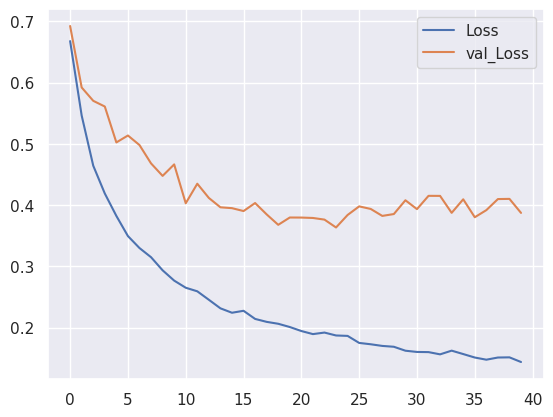

In [15]:
plt.plot(r.history["loss"], label= "Loss")
plt.plot(r.history["val_loss"], label = "val_Loss")
plt.legend();

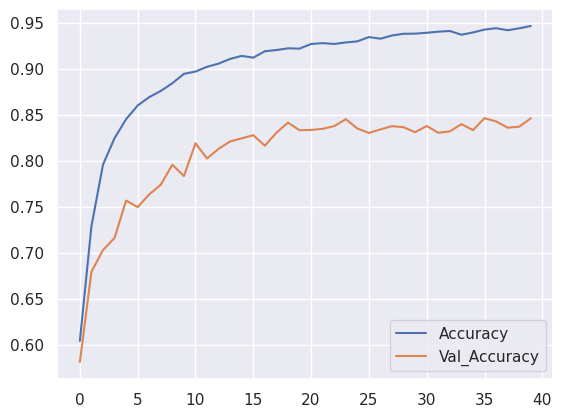

In [16]:
plt.plot(r.history["accuracy"] ,label = "Accuracy")
plt.plot(r.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

In [17]:
pd.DataFrame(r.history).to_csv("densenet.csv",index=False)

In [18]:
model.save("Densenet.h5")

## MORE TRAINING

In [19]:
LR = 0.001
EPOCHS = 30

In [20]:
model.compile(optimizer=tf.keras.optimizers.SGD(LR),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelsdir = "models"
checkpoint = ModelCheckpoint(filepath = modelsdir + "/(mt)SGD.{epoch:02d}-{val_accuracy:.4f}.h5" ,
                             monitor= "val_accuracy" , 
                             mode = "max",
                            verbose = 0,
                            save_best_only=True)

In [22]:
s = model.fit(train_generator , validation_data=(x_valid, y_valid), steps_per_epoch = spe ,epochs=EPOCHS, callbacks = [checkpoint])

Epoch 1/30
507/507 [==============================] - 179s 263ms/step - loss: 0.1404 - accuracy: 0.9475 - val_loss: 0.3694 - val_accuracy: 0.8551
Epoch 2/30
507/507 [==============================] - 135s 265ms/step - loss: 0.1288 - accuracy: 0.9520 - val_loss: 0.4737 - val_accuracy: 0.8262
Epoch 3/30
507/507 [==============================] - 134s 264ms/step - loss: 0.1168 - accuracy: 0.9553 - val_loss: 0.4518 - val_accuracy: 0.8392
Epoch 4/30
507/507 [==============================] - 138s 271ms/step - loss: 0.1096 - accuracy: 0.9594 - val_loss: 0.3242 - val_accuracy: 0.8871
Epoch 5/30
507/507 [==============================] - 137s 269ms/step - loss: 0.0984 - accuracy: 0.9631 - val_loss: 0.3968 - val_accuracy: 0.8656
Epoch 6/30
507/507 [==============================] - 136s 267ms/step - loss: 0.0947 - accuracy: 0.9633 - val_loss: 0.4006 - val_accuracy: 0.8589
Epoch 7/30
507/507 [==============================] - 135s 267ms/step - loss: 0.0854 - accuracy: 0.9700 - val_loss: 0.4685 -

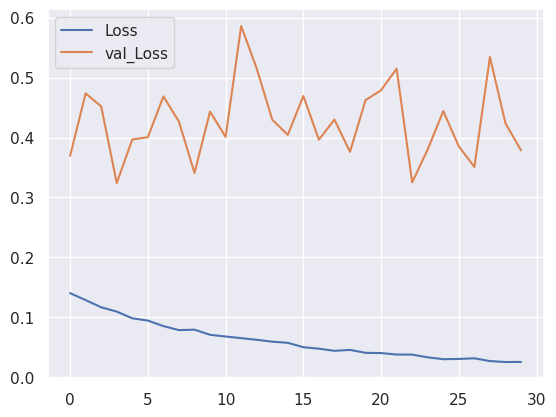

In [23]:
plt.plot(s.history["loss"], label= "Loss")
plt.plot(s.history["val_loss"], label = "val_Loss")
plt.legend();

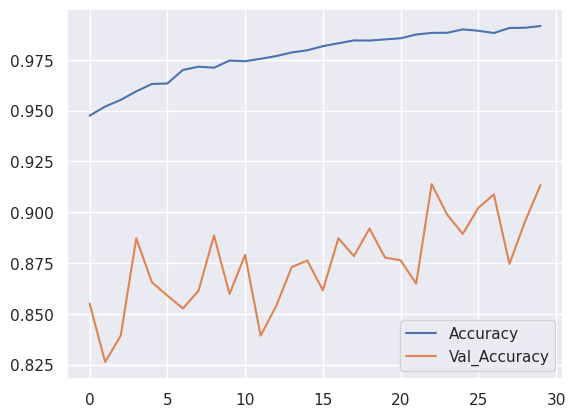

In [24]:
plt.plot(s.history["accuracy"] ,label = "Accuracy")
plt.plot(s.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

In [25]:
pd.DataFrame(s.history).to_csv("densenet-2.csv",index=False)

In [26]:
model.save("Densenet-2.h5")